In [1]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.svm import SVR
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import probplot,normaltest, anderson
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import RandomizedSearchCV,train_test_split, GridSearchCV

In [2]:
#cargar el data set
carritos = pd.read_csv('vehicle_prices.csv')

## Exploración de Datos

In [3]:
carritos.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,make
0,Corsa,2018,7885,Manual,9876,Petrol,145.0,55.4,1.4,vauxhall
1,Corsa,2019,11995,Manual,2500,Petrol,145.0,54.3,1.4,vauxhall
2,Corsa,2017,9777,Automatic,9625,Petrol,145.0,47.9,1.4,vauxhall
3,Corsa,2016,8500,Manual,25796,Petrol,30.0,55.4,1.4,vauxhall
4,Corsa,2019,10000,Manual,3887,Petrol,145.0,43.5,1.4,vauxhall


In [4]:
print(carritos.shape)

(108540, 10)


In [5]:
carritos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108540 entries, 0 to 108539
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   model         108540 non-null  object 
 1   year          108540 non-null  int64  
 2   price         108540 non-null  int64  
 3   transmission  108540 non-null  object 
 4   mileage       108540 non-null  int64  
 5   fuelType      108540 non-null  object 
 6   tax           99187 non-null   float64
 7   mpg           99187 non-null   float64
 8   engineSize    108540 non-null  float64
 9   make          108540 non-null  object 
dtypes: float64(3), int64(3), object(4)
memory usage: 8.3+ MB


In [6]:
carritos.describe()

,year,price,mileage,tax,mpg,engineSize
count,108540.000000,108540.000000,108540.000000,99187.000000,99187.000000,108540.000000
mean,2017.098028,16890.124046,23025.928469,120.299838,55.166825,1.661644
std,2.130057,9756.266820,21176.423684,63.150926,16.138522,0.557058
min,1970.000000,450.000000,1.000000,0.000000,0.300000,0.000000
25%,2016.000000,10229.500000,7491.750000,125.000000,47.100000,1.200000
50%,2017.000000,14698.000000,17265.000000,145.000000,54.300000,1.600000
75%,2019.000000,20940.000000,32236.000000,145.000000,62.800000,2.000000
max,2060.000000,159999.000000,323000.000000,580.000000,470.800000,6.600000


In [7]:
#ver cuantos nulos hay en la data
carritos.isnull().sum()

model              0
year               0
price              0
transmission       0
mileage            0
fuelType           0
tax             9353
mpg             9353
engineSize         0
make               0
dtype: int64

In [8]:
num_unique_models = carritos['model'].nunique()
print(f'Total number of different models: {num_unique_models}')

Total number of different models: 195


In [9]:
#ver cuantos carros hay por tipo de transmission
carritos.groupby(['transmission']).size()

transmission
Automatic    22319
Manual       61308
Other           10
Semi-Auto    24903
dtype: int64

In [10]:
#ver cuantos carros hay por tipo de fuel
carritos.groupby(['fuelType']).size()

fuelType
Diesel      45177
Electric        6
Hybrid       3229
Other         253
Petrol      59875
dtype: int64

In [11]:
#ver cuantos carros hay por tipo de make
carritos.groupby(['make']).size()

make
audi        10668
bmw         10781
ford        23419
hyundai      4860
mercedes    17018
skoda        6267
toyota       6738
vauxhall    13632
vw          15157
dtype: int64

In [12]:
#ver cuantos carros hay por tipo de modelo
carritos['model'].value_counts().head(5)

model
Focus      10042
C Class     7646
Fiesta      6557
Golf        4863
Corsa       3441
Name: count, dtype: int64

In [13]:
#Iterar a través de las columnas numéricas y realizar el test de normalidad
for col in carritos.select_dtypes(include='number').columns:
    print(f"\nNormality test results for {col}:")
    
    # Test de D'Agostino's K^2
    _, p_normaltest = normaltest(carritos[col])
    print(f"D'Agostino's K^2 Test p-value: {p_normaltest}")
    
    # Test de Anderson-Darling
    result_anderson = anderson(carritos[col])
    print(f"Anderson-Darling Test Statistic: {result_anderson.statistic}")
    print(f"Anderson-Darling Critical Values: {result_anderson.critical_values}")



Normality test results for year:
D'Agostino's K^2 Test p-value: 0.0
Anderson-Darling Test Statistic: 3350.954875607873
Anderson-Darling Critical Values: [0.576 0.656 0.787 0.918 1.092]

Normality test results for price:
D'Agostino's K^2 Test p-value: 0.0
Anderson-Darling Test Statistic: 3250.341430425804
Anderson-Darling Critical Values: [0.576 0.656 0.787 0.918 1.092]

Normality test results for mileage:
D'Agostino's K^2 Test p-value: 0.0
Anderson-Darling Test Statistic: 3751.778363853329
Anderson-Darling Critical Values: [0.576 0.656 0.787 0.918 1.092]

Normality test results for tax:
D'Agostino's K^2 Test p-value: nan
Anderson-Darling Test Statistic: nan
Anderson-Darling Critical Values: [0.576 0.656 0.787 0.918 1.092]

Normality test results for mpg:
D'Agostino's K^2 Test p-value: nan
Anderson-Darling Test Statistic: nan
Anderson-Darling Critical Values: [0.576 0.656 0.787 0.918 1.092]

Normality test results for engineSize:
D'Agostino's K^2 Test p-value: 0.0
Anderson-Darling Test

In [14]:
#Revisar outliers usando el método de cuantiles (percentiles)
def detect_outliers(data, col_name):
    q1 = data[col_name].quantile(0.25)
    q3 = data[col_name].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = data[(data[col_name] < lower_bound) | (data[col_name] > upper_bound)]
    return outliers

#Detectar outliers para engineSize
outliers_engineSize = detect_outliers(carritos, 'engineSize')
print('Outliers para engineSize:')
print(outliers_engineSize[['engineSize']])

#Detectar outliers para year
outliers_year = detect_outliers(carritos, 'year')
print('\nOutliers para year:')
print(outliers_year[['year']])

#Detectar outliers para tax
outliers_tax = detect_outliers(carritos, 'tax')
print('\nOutliers para tax:')
print(outliers_tax[['tax']])

#Detectar outliers para mileage
outliers_mileage = detect_outliers(carritos, 'mileage')
print('\nOutliers para mileage:')
print(outliers_mileage[['mileage']])

#Detectar outliers para mpg
outliers_mpg = detect_outliers(carritos, 'mpg')
print('\nOutliers para mpg:')
print(outliers_mpg[['mpg']])

Outliers para engineSize:
        engineSize
13992          4.4
14353          4.4
14421          4.4
14539          4.4
14541          4.4
...            ...
108411         5.5
108423         5.5
108459         4.0
108479         5.5
108481         4.0

[755 rows x 1 columns]

Outliers para year:
        year
6       2011
13      2009
24      2008
26      2009
2497    2010
...      ...
108188  2004
108191  2010
108301  2011
108380  2009
108457  2000

[1946 rows x 1 columns]

Outliers para tax:
          tax
3        30.0
9        30.0
10       30.0
12       30.0
13       30.0
...       ...
108511   20.0
108512  305.0
108513  240.0
108517  260.0
108529   30.0

[28815 rows x 1 columns]

Outliers para mileage:
        mileage
12        80000
26        86558
115       89883
233       71029
554       70128
...         ...
108187   118000
108188    86000
108204    84000
108287    73000
108325   240494

[4360 rows x 1 columns]

Outliers para mpg:
          mpg
46       88.3
364      88.3
621

## Visualización de Datos

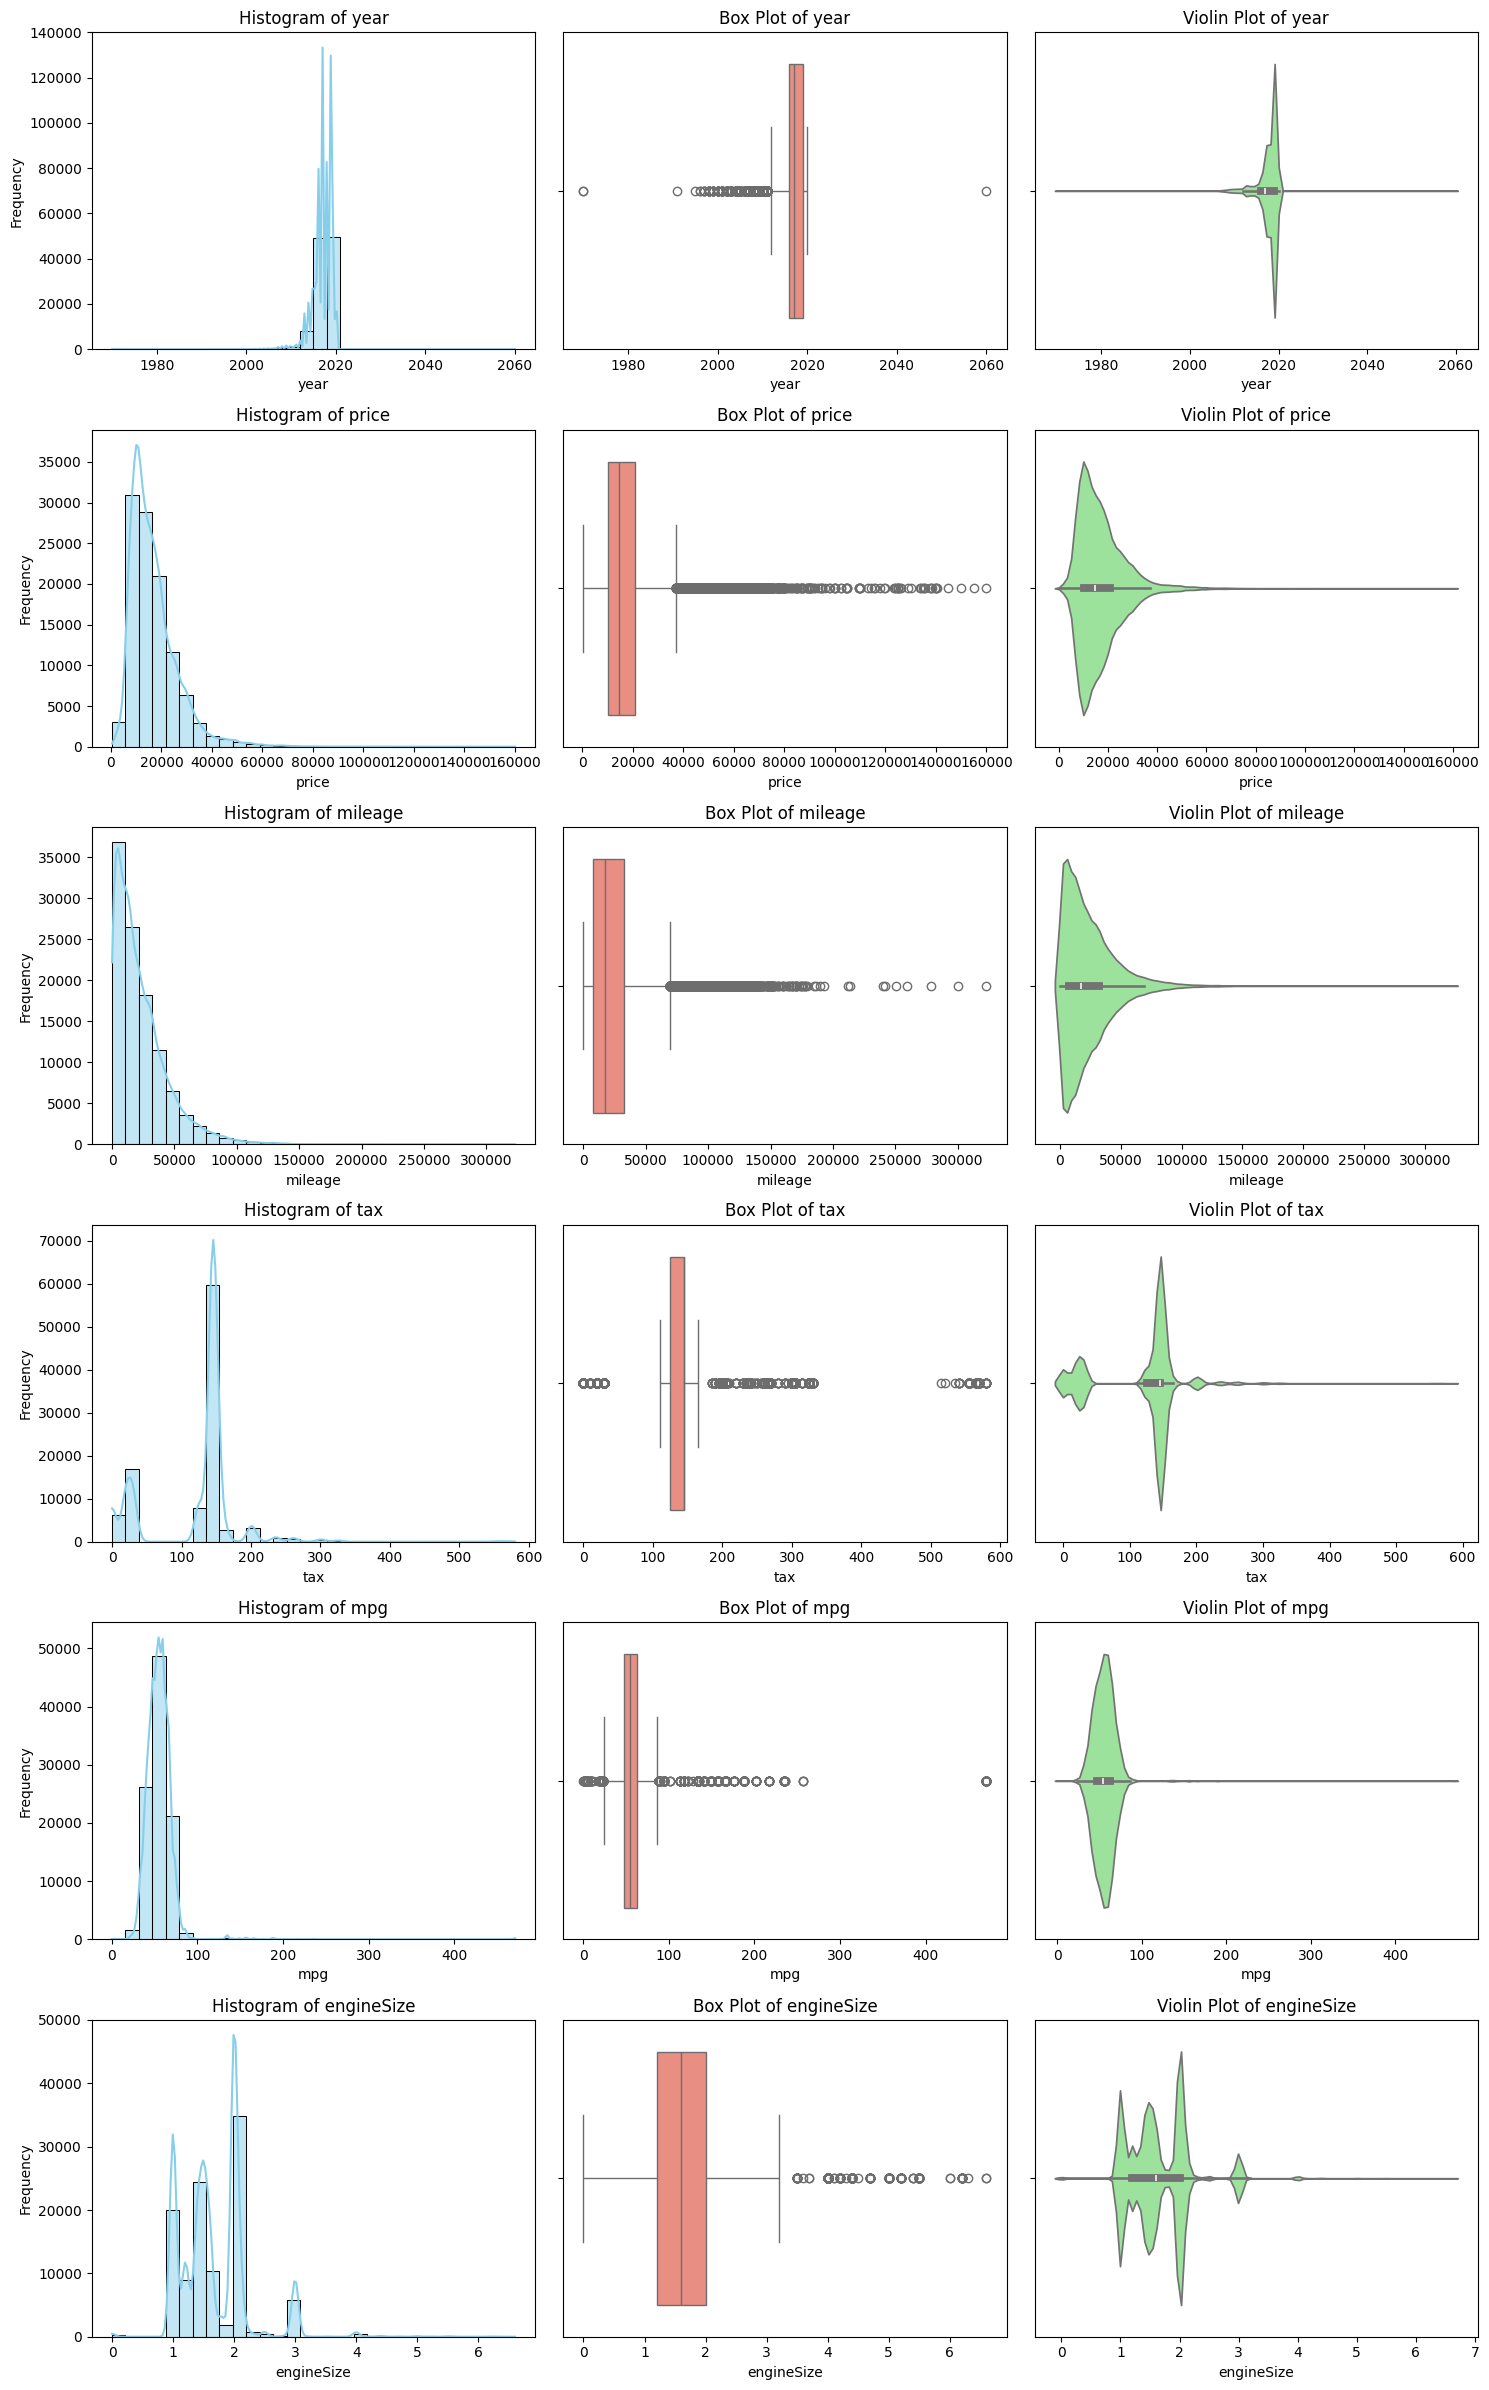

In [15]:
fig, axes = plt.subplots(nrows=len(carritos.select_dtypes(include=[np.number]).columns), ncols=3, figsize=(15, 4*len(carritos.select_dtypes(include=[np.number]).columns)))

#Iterar a través de las columnas numéricas y crear las graficas
for idx, column in enumerate(carritos.select_dtypes(include=[np.number]).columns):
    # Histogram
    sns.histplot(carritos[column], bins=30, kde=True, color='skyblue', ax=axes[idx][0])
    axes[idx][0].set_xlabel(column)
    axes[idx][0].set_ylabel('Frequency')
    axes[idx][0].set_title(f'Histogram of {column}')
    
    # Box plot
    sns.boxplot(x=carritos[column], color='salmon', ax=axes[idx][1])
    axes[idx][1].set_xlabel(column)
    axes[idx][1].set_title(f'Box Plot of {column}')
    
    # Violin plot
    sns.violinplot(x=carritos[column], color='lightgreen', ax=axes[idx][2])
    axes[idx][2].set_xlabel(column)
    axes[idx][2].set_title(f'Violin Plot of {column}')

plt.tight_layout()
plt.show()

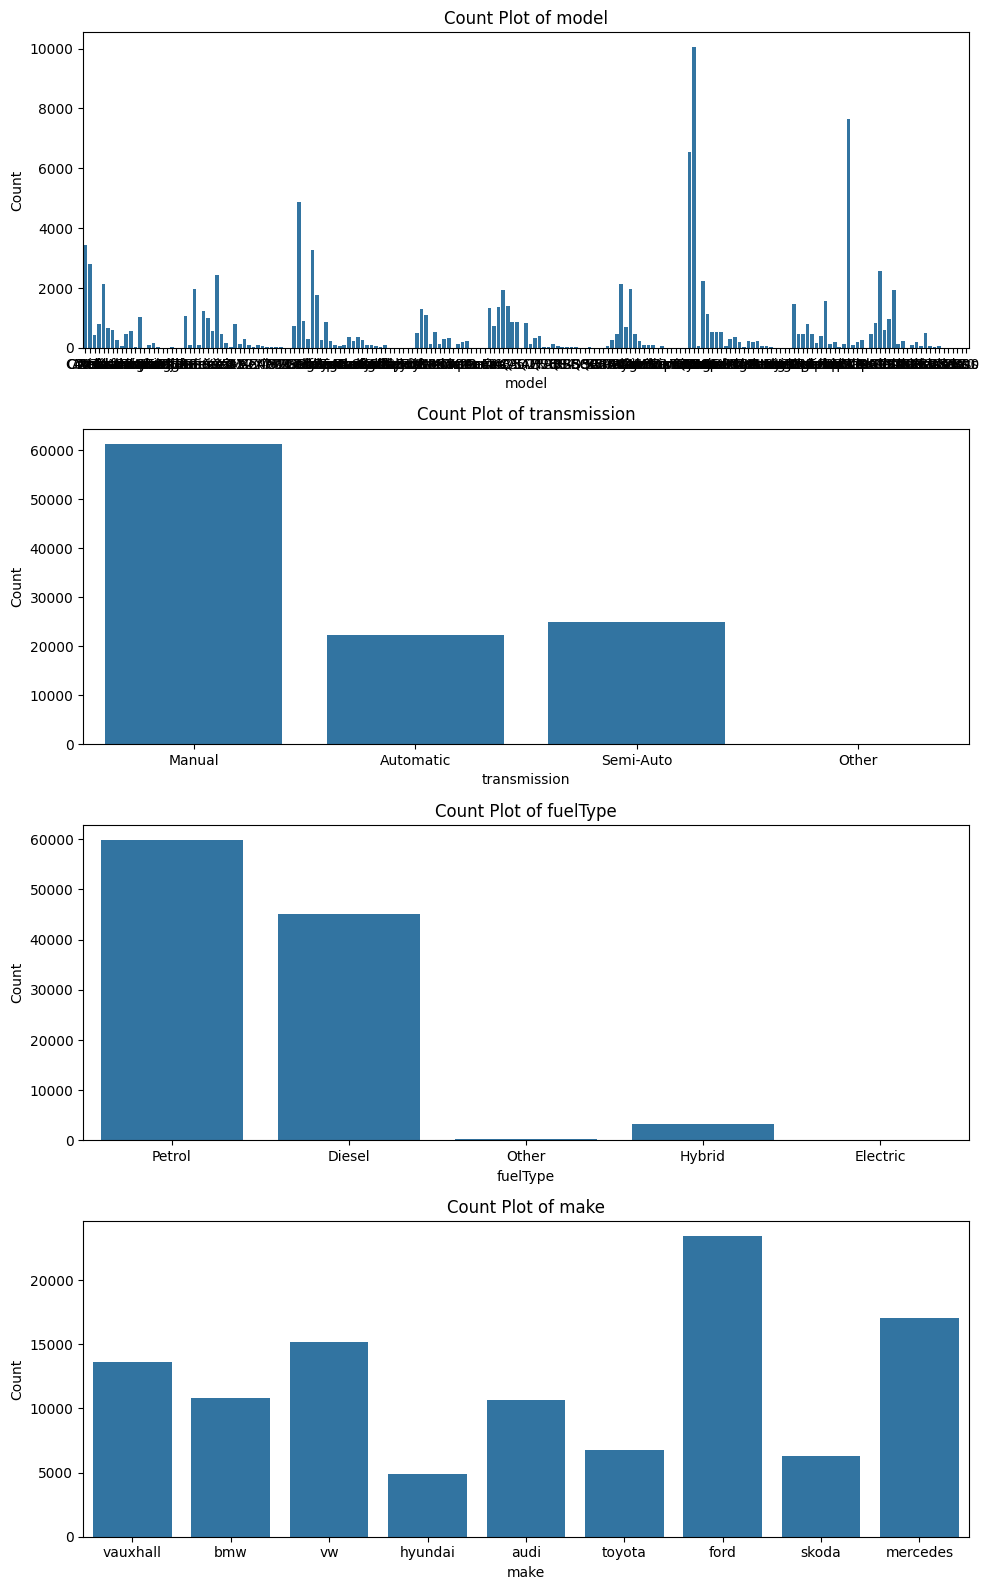

In [16]:
#Filtrar columnas categoricas
categorical_cols = carritos.select_dtypes(include=['object'])

#Create subplots for each categorical variable with count plots
fig, axes = plt.subplots(nrows=len(categorical_cols.columns), ncols=1, figsize=(10, 4*len(categorical_cols.columns)))

#Iterate through each categorical column and create count plots
for idx, column in enumerate(categorical_cols.columns):
    sns.countplot(x=column, data=carritos, ax=axes[idx])
    axes[idx].set_xlabel(column)
    axes[idx].set_ylabel('Count')
    axes[idx].set_title(f'Count Plot of {column}')
    
plt.tight_layout()
plt.show()

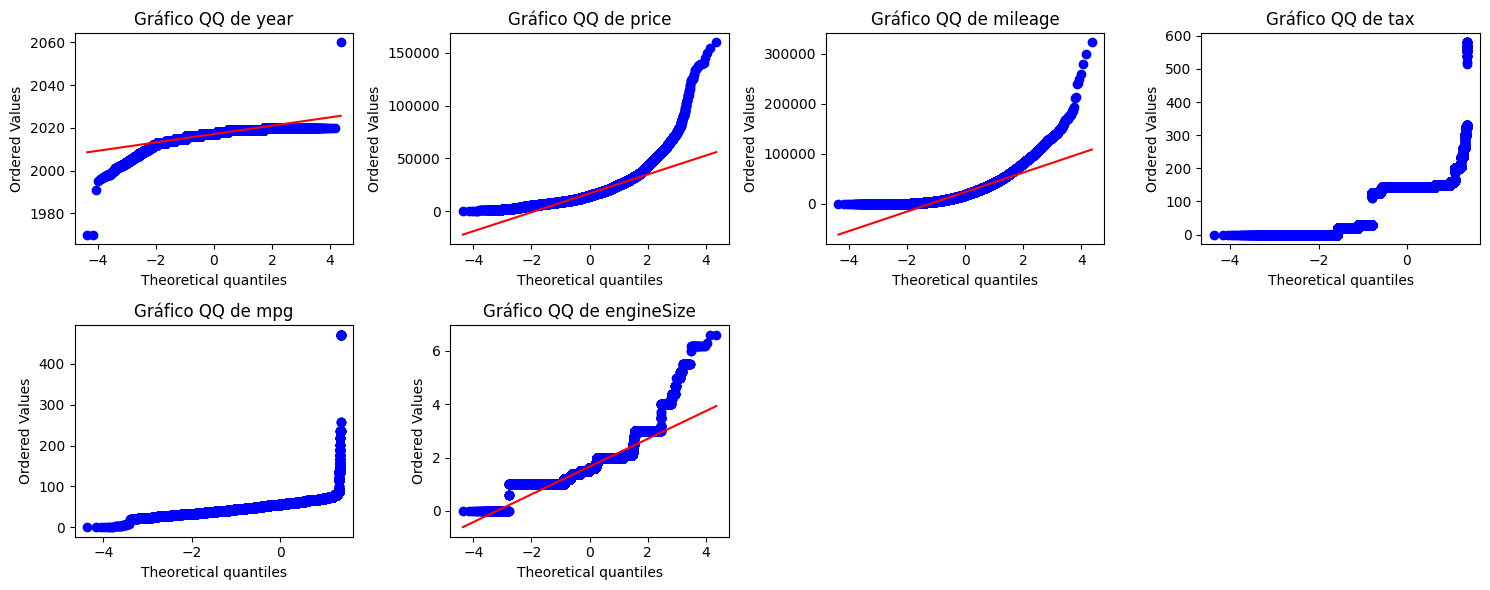

In [17]:
#Obtener las columnas numéricas
numeric_columns = carritos.select_dtypes(include=np.number).columns

#Calcular el número de filas y columnas necesarias en función del número de columnas numéricas
num_cols = len(numeric_columns)
num_rows = (num_cols - 1) // 4 + 1  # Ajustar el número de columnas según sea necesario

#Crear una cuadrícula de subgráficos
fig, axes = plt.subplots(num_rows, 4, figsize=(15, 3 * num_rows))

#Aplanar el array de ejes
axes = axes.flatten()

#Iterar a través de las columnas numéricas y crear gráficos QQ
for i, col in enumerate(numeric_columns):
    probplot(carritos[col], plot=axes[i])
    axes[i].set_title(f'Gráfico QQ de {col}')

#Eliminar ejes sobrantes si es necesario
for j in range(num_cols, num_rows * 4):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

/var/folders/57/c9zjxddn221c056sd800540w0000gn/T/ipykernel_1047/2844524207.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_models.index, x=top_models.values, palette='viridis')


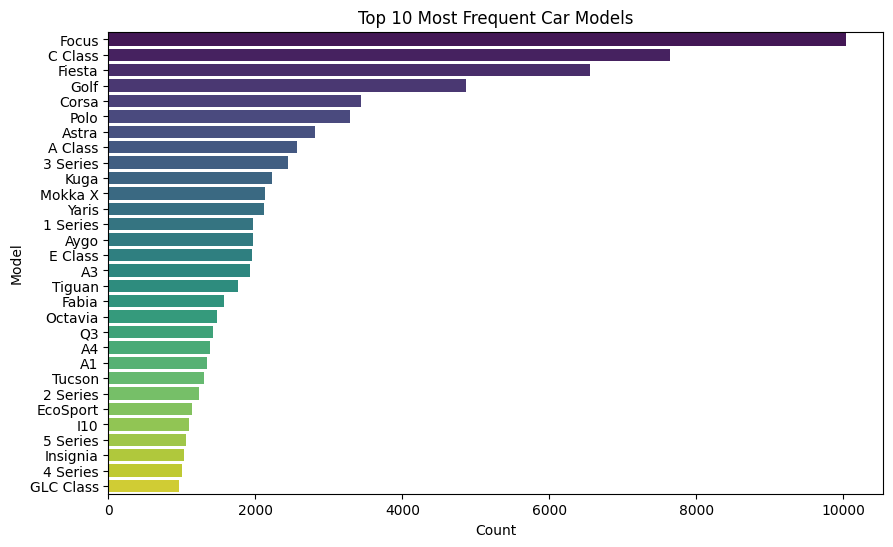

In [18]:
top_models = carritos['model'].value_counts().nlargest(30)  

#Create a horizontal bar chart for top models
plt.figure(figsize=(10, 6))
sns.barplot(y=top_models.index, x=top_models.values, palette='viridis')
plt.xlabel('Count')
plt.ylabel('Model')
plt.title('Top 10 Most Frequent Car Models')
plt.show()

## Imputacion de Datos

In [19]:
carritos['tax'].fillna(carritos['tax'].mean(), inplace=True)

In [20]:
#Update year values to 2020 where year is 2060
carritos.loc[carritos['year'] == 2060, 'year'] = 2020

## Matriz de Correlación

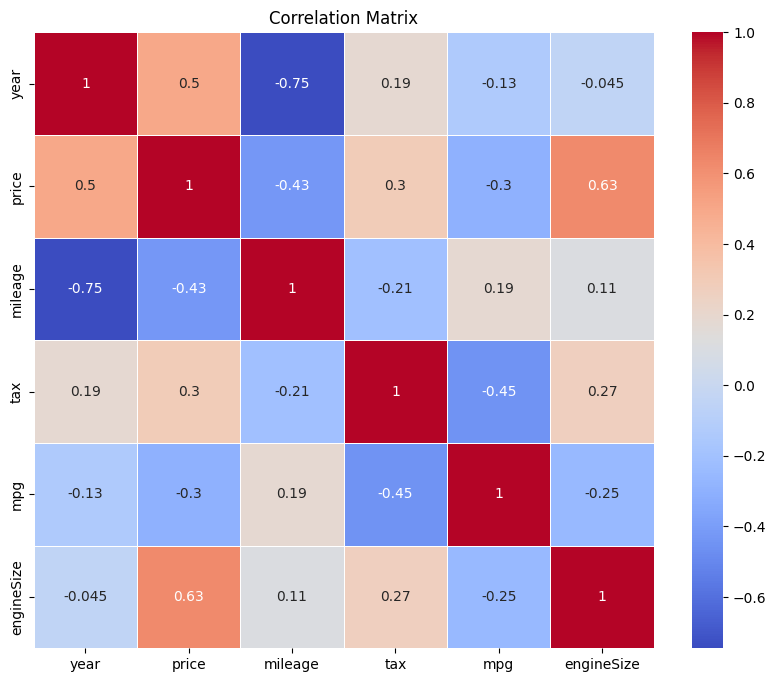

In [21]:
#Elegir solo las columnas numericas
numeric_cols = carritos.select_dtypes(include=[np.number])
#calcular la matriz
correlation_matrix = numeric_cols.corr()
correlation_matrix
#Graficar el mapa de calor
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [22]:
correlation_matrix

,year,price,mileage,tax,mpg,engineSize
year,1.000000,0.498206,-0.745102,0.186638,-0.132918,-0.044894
price,0.498206,1.000000,-0.427944,0.297425,-0.296429,0.631580
mileage,-0.745102,-0.427944,1.000000,-0.210757,0.185657,0.108246
tax,0.186638,0.297425,-0.210757,1.000000,-0.451451,0.266427
mpg,-0.132918,-0.296429,0.185657,-0.451451,1.000000,-0.248210
engineSize,-0.044894,0.631580,0.108246,0.266427,-0.248210,1.000000


## Variance Inflation Factor (VIF)

In [23]:
#Eliminar filas con valores faltantes en el DataFrame
carritos_cleaned = carritos.dropna()

#Obtener las columnas numéricas para el cálculo del VIF
numeric_columns = carritos_cleaned.select_dtypes(include=np.number).columns

#Crear un DataFrame auxiliar con las columnas numéricas para el cálculo del VIF
X_vif = carritos_cleaned[numeric_columns]

# Calcular el VIF para cada variable predictora
vif_data = pd.DataFrame()
vif_data["Variable"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

print(vif_data)

     Variable        VIF
0        year  38.833089
1       price  11.118769
2     mileage   3.895874
3         tax   6.275095
4         mpg  16.602222
5  engineSize  24.565794


# Modelos

## Regresión Linear

In [24]:
# Separar columnas categoricas y numericas
numerical_cols = ['year', 'mileage', 'tax', 'mpg', 'engineSize']
categorical_cols = ['model', 'transmission', 'fuelType', 'make']

#Definicion del los pasos de prepocesamiento
numerical_transformer = SimpleImputer(strategy='mean')
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Create a pipeline with preprocessing and linear regression model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

#Divide los datos en conjuntos de entrenamiento y validación
X = carritos.drop('price', axis=1)
y = carritos['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Realiza predicciones
y_pred = pipeline.predict(X_test)

#Evaluacion del modelo
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f'Regresión Linear - Mean Squared Error (MSE): {mse}')
print(f'Regresion Linear - Mean Absolute Error (MAE): {mae}')


Regresión Linear - Mean Squared Error (MSE): 21845440.779914975
Regresion Linear - Mean Absolute Error (MAE): 2897.9600165735205


## Random Forest 

In [25]:
#con todas la variables
X = carritos.drop('price', axis=1)
y = carritos['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor())
])
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f'Random Forest Regression MSE: {mse}')
print(f'Random Forest Regression MAE: {mae}')

Random Forest Regression MSE: 4227908.623432534
Random Forest Regression MAE: 1157.5626690856081


In [26]:
X = carritos.drop('price', axis=1)
y = carritos['price']
num_prueba = ['year', 'tax', 'mpg', 'engineSize', 'mileage']
cat_prueba = ['transmission', 'fuelType', 'model', 'make']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define preprocessing steps for numerical and categorical columns
numerical_transformer = SimpleImputer(strategy='mean')
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Initialize lists to store results
mse_results = []
mae_results = []

# Iterate over numerical columns
for col in num_prueba:
    # Exclude the current numerical column from the training data
    num_cols_exclude = [c for c in num_prueba if c != col]
    
    # Combine preprocessing steps using ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, num_cols_exclude),
            ('cat', categorical_transformer, cat_prueba)
        ])
    
    # Create a pipeline with preprocessing and RandomForestRegressor model
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor())
    ])
    
    # Fit the pipeline on training data
    pipeline.fit(X_train, y_train)
    
    # Make predictions on test data
    y_pred = pipeline.predict(X_test)
    
    # Calculate MSE and MAE
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    
    # Store results
    mse_results.append(mse)
    mae_results.append(mae)

# Iterate over categorical columns
for col in cat_prueba:
    # Exclude the current categorical column from the training data
    cat_cols_exclude = [c for c in cat_prueba if c != col]
    
    # Combine preprocessing steps using ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, num_prueba),
            ('cat', categorical_transformer, cat_cols_exclude)
        ])
    
    # Create a pipeline with preprocessing and RandomForestRegressor model
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor())
    ])
    
    # Fit the pipeline on training data
    pipeline.fit(X_train, y_train)
    
    # Make predictions on test data
    y_pred = pipeline.predict(X_test)
    
    # Calculate MSE and MAE
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    
    # Store results
    mse_results.append(mse)
    mae_results.append(mae)

# Print results for numerical columns
for i, col in enumerate(num_prueba):
    print(f'Excluding {col}:')
    print(f'Random Forest Regression MSE: {mse_results[i]}')
    print(f'Random Forest Regression MAE: {mae_results[i]}\n')

# Print results for categorical columns
for i, col in enumerate(cat_prueba):
    print(f'Excluding {col}:')
    print(f'Random Forest Regression MSE: {mse_results[i + len(num_prueba)]}')
    print(f'Random Forest Regression MAE: {mae_results[i + len(num_prueba)]}\n')

Excluding year:
Random Forest Regression MSE: 5249696.441850581
Random Forest Regression MAE: 1400.9034605668337

Excluding tax:
Random Forest Regression MSE: 4300304.360574036
Random Forest Regression MAE: 1169.3307579641044

Excluding mpg:
Random Forest Regression MSE: 5392942.989092103
Random Forest Regression MAE: 1317.4009792737068

Excluding engineSize:
Random Forest Regression MSE: 5624442.627101484
Random Forest Regression MAE: 1278.7913365379836

Excluding mileage:
Random Forest Regression MSE: 4957081.202293542
Random Forest Regression MAE: 1302.4407204686152

Excluding transmission:
Random Forest Regression MSE: 4260566.806634043
Random Forest Regression MAE: 1199.3753272793804

Excluding fuelType:
Random Forest Regression MSE: 4268843.6443066755
Random Forest Regression MAE: 1164.161178400016

Excluding model:
Random Forest Regression MSE: 5702179.64361142
Random Forest Regression MAE: 1338.0175219265875

Excluding make:
Random Forest Regression MSE: 4347816.494239715
Rando

## SVR

In [27]:
# Define preprocessing steps for numerical and categorical columns
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

# Create a pipeline with preprocessing and SVR model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', SVR())
])

# Split the data into training and test sets
X = carritos.drop('price', axis=1)
y = carritos['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Make predictions using the pipeline
y_pred = pipeline.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f'SVR - Mean Squared Error (MSE): {mse}')
print(f'SVR - Mean Absolute Error (MAE): {mae}')


SVR - Mean Squared Error (MSE): 62188055.674474105
SVR - Mean Absolute Error (MAE): 4594.354610004292


## Decision Tree

In [28]:
# Define preprocessing steps for numerical and categorical columns
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
# Combine preprocessing steps using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

decision_tree_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', DecisionTreeRegressor())
])
# Split the data into training and test sets
X = carritos.drop('price', axis=1)
y = carritos['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# Fit and evaluate Decision Tree model
decision_tree_pipeline.fit(X_train, y_train)
y_pred_dt = decision_tree_pipeline.predict(X_test)
mse_dt = mean_squared_error(y_test, y_pred_dt)
mae_dt = mean_absolute_error(y_test, y_pred_dt)
print(f'Decision Tree - Mean Squared Error (MSE): {mse_dt}')
print(f'Decision Tree - Mean Absolute Error (MAE): {mae_dt}')

Decision Tree - Mean Squared Error (MSE): 6656946.3240074515
Decision Tree - Mean Absolute Error (MAE): 1425.2801959793312


# Grid Search

In [29]:
# # Define preprocessing steps for numerical and categorical columns
# numerical_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='mean')),
#     ('scaler', StandardScaler())
# ])

# categorical_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
#     ('onehot', OneHotEncoder(handle_unknown='ignore'))
# ])

# # Combine preprocessing steps using ColumnTransformer
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', numerical_transformer, numerical_cols),
#         ('cat', categorical_transformer, categorical_cols)
#     ]
# )

# # Create a pipeline with preprocessing and SVR model
# pipeline = Pipeline(steps=[
#     ('preprocessor', preprocessor),
#     ('regressor', SVR())
# ])

# # Define hyperparameters grid for Grid Search
# param_grid = {
#     'regressor__kernel': ['linear', 'rbf', 'poly'],  # Kernel type
#     'regressor__C': [0.1, 1, 10],  # Regularization parameter
#     'regressor__gamma': ['scale', 'auto'],  # Kernel coefficient for 'rbf' and 'poly'
# }

# # Split the data into training and test sets
# X = carritos.drop('price', axis=1)
# y = carritos['price']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Perform Grid Search with cross-validation
# grid_search = GridSearchCV(pipeline, param_grid, cv=5)
# grid_search.fit(X_train, y_train)

# # Get the best model from the grid search
# best_svr_model = grid_search.best_estimator_

# # Make predictions using the best model
# y_pred_svr = best_svr_model.predict(X_test)

# # Evaluate the best model
# mse_svr = mean_squared_error(y_test, y_pred_svr)
# mae_svr = mean_absolute_error(y_test, y_pred_svr)
# print(f'Best SVR Model - Mean Squared Error (MSE): {mse_svr}')
# print(f'Best SVR Model - Mean Absolute Error (MAE): {mae_svr}')

In [30]:
# # Define preprocessing steps for numerical and categorical columns
# numerical_transformer = SimpleImputer(strategy='mean')
# categorical_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
#     ('onehot', OneHotEncoder(handle_unknown='ignore'))
# ])

# # Combine preprocessing steps using ColumnTransformer
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', numerical_transformer, numerical_cols),
#         ('cat', categorical_transformer, categorical_cols)
#     ])

# # Create a pipeline with preprocessing and RandomForestRegressor model
# pipeline = Pipeline(steps=[
#     ('preprocessor', preprocessor),
#     ('regressor', RandomForestRegressor())
# ])

# # Define hyperparameters grid for Grid Search
# param_grid = {
#     'regressor__n_estimators': [100, 200, 300],
#     'regressor__max_depth': [None, 10, 20],
#     'regressor__min_samples_split': [2, 5, 10],
# }

# # Split the data into training and test sets
# X = carritos.drop('price', axis=1)
# y = carritos['price']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# # Perform Grid Search with cross-validation
# grid_search = GridSearchCV(pipeline, param_grid, cv=5)
# grid_search.fit(X_train, y_train)

# # Get the best model from the grid search.
# best_rf_model = grid_search.best_estimator_

# # Make predictions using the best model
# y_pred_rf = best_rf_model.predict(X_test)

# # Evaluate the best model
# mse_rf = mean_squared_error(y_test, y_pred_rf)
# mae_rf = mean_absolute_error(y_test, y_pred_rf)
# print(f'Best Random Forest Regression Model - Mean Squared Error (MSE): {mse_rf}')
# print(f'Best Random Forest Regression Model - Mean Absolute Error (MAE): {mae_rf}')

In [31]:
# # Specify the file name to save the model
# filename = 'best_rf_model.pkl'

# # Open the file using binary write mode ('wb')
# with open(filename, 'wb') as file:
#     # Use pickle.dump to save the model to the file
#     pickle.dump(best_rf_model, file)

# Randomized SearchCV

In [32]:
# # Define preprocessing steps for numerical and categorical columns
# numerical_transformer = SimpleImputer(strategy='mean')
# categorical_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
#     ('onehot', OneHotEncoder(handle_unknown='ignore'))
# ])

# # Combine preprocessing steps using ColumnTransformer
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', numerical_transformer, numerical_cols),
#         ('cat', categorical_transformer, categorical_cols)
#     ])

# # Create a pipeline with preprocessing and RandomForestRegressor model
# pipeline = Pipeline(steps=[
#     ('preprocessor', preprocessor),
#     ('regressor', RandomForestRegressor())
# ])

# # Define hyperparameters grid for Randomized Search
# param_distributions = {
#     'regressor__n_estimators': [200, 300, 500],
#     'regressor__max_depth': [None, 15, 30],
#     'regressor__min_samples_split': [2, 5, 10],
# }

# # Split the data into training and test sets
# X = carritos.drop('price', axis=1)
# y = carritos['price']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# # Perform Randomized Search with cross-validation
# random_search = RandomizedSearchCV(pipeline, param_distributions, n_iter=10, cv=5, random_state=42)
# random_search.fit(X_train, y_train)

# # Get the best model from the randomized search
# best_rf_model = random_search.best_estimator_

# # Make predictions using the best model
# y_pred_rf = best_rf_model.predict(X_test)

# # Evaluate the best model
# mse_rf = mean_squared_error(y_test, y_pred_rf)
# mae_rf = mean_absolute_error(y_test, y_pred_rf)
# print(f'Best Random Forest Regression Model - Mean Squared Error (MSE): {mse_rf}')
# print(f'Best Random Forest Regression Model - Mean Absolute Error (MAE): {mae_rf}')


Best Random Forest Regression Model - Mean Squared Error (MSE): 4226920.555108917
Best Random Forest Regression Model - Mean Absolute Error (MAE): 1156.6058582846038


In [33]:
# Define preprocessing steps for numerical and categorical columns
numerical_transformer = SimpleImputer(strategy='mean')
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Create a pipeline with preprocessing and RandomForestRegressor model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor())
])

# Define hyperparameters grid for Randomized Search
param_distributions = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_depth': [None, 10, 20],
    'regressor__min_samples_split': [2, 5, 10],
}

# Split the data into training and test sets
X = carritos.drop('price', axis=1)
y = carritos['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Perform Randomized Search with cross-validation
random_search = RandomizedSearchCV(pipeline, param_distributions, n_iter=10, cv=5, random_state=42)
random_search.fit(X_train, y_train)

# Get the best model from the randomized search
best_rf_model = random_search.best_estimator_

# Make predictions using the best model
y_pred_rf = best_rf_model.predict(X_test)

# Evaluate the best model
mse_rf = mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
print(f'Best Random Forest Regression Model - Mean Squared Error (MSE): {mse_rf}')
print(f'Best Random Forest Regression Model - Mean Absolute Error (MAE): {mae_rf}')
